In [1]:
import numpy as np
import cvxpy as cp
import pandas as pd
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch,random
import empyrical as emp
from pandas_datareader import data as pdr
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [2]:
factors = pd.read_csv('factors.csv', index_col=0, parse_dates=True)
dataset_log_returns = pd.read_csv('dataset.csv', index_col=0, parse_dates=True)
stocks = list(dataset_log_returns.columns.values)
indices = list(factors.columns.values)
indices.insert(0,'alpha')
N = len(stocks)

# Q1

part (a)

We know $\mathbf{x}^T\boldsymbol{\Sigma}\mathbf{x}$ is convex as it is a positive-semidewfinite matrix, because 

$$\boldsymbol\Sigma = \mathbb{E}[(\mathbf{X}-\mathbb{E}[\mathbf{X}])(\mathbf{X}-\mathbb{E}[\mathbf{X}])^\top]$$

and 

\begin{align}
    \mathbf{z}^\top\boldsymbol{\Sigma}\mathbf{z} 
    &= \mathbf{z}^\top\mathbb{E}[(\mathbf{X}-\mathbb{E}[\mathbf{X}])(\mathbf{X}-\mathbb{E}[\mathbf{X}])^\top]\mathbf{z} \\
    &= \mathbb{E}[\mathbf{z}^\top(\mathbf{X}-\mathbb{E}[\mathbf{X}])(\mathbf{X}-\mathbb{E}[\mathbf{X}])^\top\mathbf{z}] \\
    &= \mathbb{E}[\vert\vert(\mathbf{X}-\mathbb{E}[\mathbf{X}])^\top\mathbf{z}\vert\vert^2] \geq 0.
\end{align}

log(x) is a concave function as it's second derivative is negative: 

$$g''(x)=(\log(x))''=\biggl(\frac1x\biggr)'=-\frac1{x^2}<{0}$$

so $-c^Tlog(x)$ is a convex function (we have $c\ge{0}$ ). And a nonnegative linear combination of two convex functions is a convex function, so the minimize objective function is convex. Obviously the constraint function $x\ge{0}$ is convex. So the problem is convex. 

In [3]:
log_ret = dataset_log_returns.loc["2015-01-06": "2015-05-29",:]
c1 = np.array([0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1])
c2 = np.array([0.2,0.2,0.2,0.05,0.05,0.05,0.05,0.05,0.05,0.1])
c3 = np.array([0.15,0.25,0.1,0.1,0.02,0.02,0.02,0.02,0.02,0.3])
cov_sig = np.cov(log_ret.T)

def calculate_w(c):
    X = cp.Variable(N)
    objective = cp.Minimize(1/2 * cp.quad_form(X, cov_sig) - c * cp.log(X))
    constraint = [X >= 0]
    prob = cp.Problem(objective, constraints = constraint)
    result = prob.solve()
    x = X.value
    w = x / (np.ones(N).T @ x)
    return w

w1 = calculate_w(c1)
w2 = calculate_w(c2)
w3 = calculate_w(c3)

In [4]:
RRC_1 = w1 * (cov_sig @ w1) / (w1.T @ cov_sig @ w1)
RRC_2 = w2 * (cov_sig @ w2) / (w2.T @ cov_sig @ w2)
RRC_3 = w3 * (cov_sig @ w3) / (w3.T @ cov_sig @ w3)

In [5]:
data = np.hstack((np.vstack((w1,w2,w3)).T, np.vstack((RRC_1,RRC_2,RRC_3)).T))
df = pd.DataFrame(data, index = stocks, columns = ['w1', 'w2', 'w3', 'RRC_1', 'RRC_2', 'RRC_3'])
df

,w1,w2,w3,RRC_1,RRC_2,RRC_3
TRIP,0.052257,0.102788,0.094561,0.1,0.20,0.15
DVN,0.093043,0.164270,0.232939,0.1,0.20,0.25
DTE,0.112950,0.224457,0.151035,0.1,0.20,0.10
TGT,0.114562,0.074210,0.153516,0.1,0.05,0.10
IDXX,0.071156,0.051785,0.028312,0.1,0.05,0.02
IBM,0.095577,0.057082,0.030131,0.1,0.05,0.02
IQV,0.106308,0.065129,0.031565,0.1,0.05,0.02
VZ,0.170377,0.111060,0.056372,0.1,0.05,0.02
OMC,0.121794,0.074723,0.039742,0.1,0.05,0.02
UAL,0.061975,0.074496,0.181827,0.1,0.10,0.30


Text(0.5, 1.0, 'Capital Allocation')

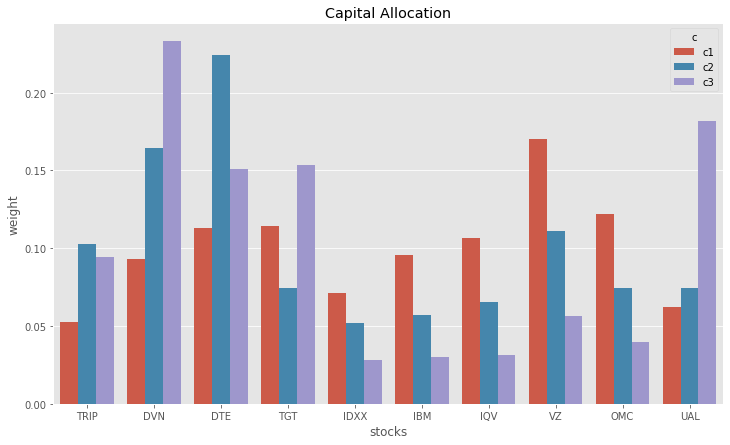

In [6]:
df = dict(weight = np.concatenate([w1,w2,w3]),
                  stocks = 3 * stocks,
                  c = sum([len(stocks)*[name] for name in ['c1', 'c2', 'c3']], []))
df2 = dict(RRC_value = np.concatenate([RRC_1,RRC_2,RRC_3]),
                  stocks = 3 * stocks,
                  c = sum([len(stocks)*[name] for name in ['c1', 'c2', 'c3']], []))
df = pd.DataFrame(df)
# plot to compare the allocations\
plt.figure(figsize=(12, 7))
ax = sns.barplot(x='stocks', y='weight', hue='c', data=df)
ax.set_title("Capital Allocation")

Text(0.5, 1.0, 'RRC Distribution')

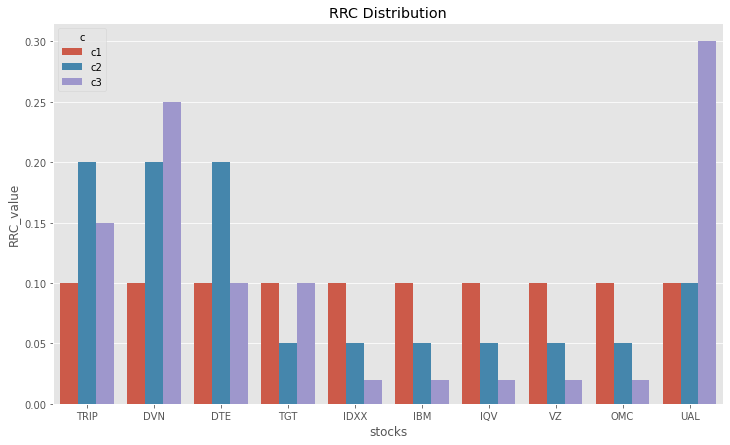

In [27]:
df2 = pd.DataFrame(df2)
# plot to compare the allocations
plt.figure(figsize=(12, 7))
ax = sns.barplot(x='stocks', y='RRC_value', hue='c', data=df2)
ax.set_title("RRC Distribution")

# Q2

In [8]:
def getQuasiDiag(link):
    link=link.astype(int)
    sortIx=pd.Series([link[-1,0],link[-1,1]])
    numItems=link[-1,3]
    while sortIx.max()>=numItems:
        sortIx.index=range(0,sortIx.shape[0]*2,2)
        df0=sortIx[sortIx>=numItems]
        i=df0.index;j=df0.values-numItems
        sortIx[i]=link[j,0]
        df0=pd.Series(link[j,1],index=i+1)
        sortIx=sortIx.append(df0)
        sortIx=sortIx.sort_index()
        sortIx.index=range(sortIx.shape[0])
    return sortIx.tolist()

def correlDist(corr, n_stock):
    dist=((1-corr)/2.)**.5
    for i in range(n_stock):
        dist.iloc[i,i] = 0
    return dist

def plotCorrMatrix(path,corr,labels=None):
    if labels is None:labels=[]
    plt.pcolor(corr)
    plt.colorbar()
    plt.yticks(np.arange(.5,corr.shape[0]+.5),labels)
    plt.xticks(np.arange(.5,corr.shape[0]+.5),labels)
    plt.savefig(path)
    plt.clf();plt.close()
    return

def hrp_s12(cov,stock_namelist, ifplot = False):
    n_stock = len(stock_namelist)
 #1) compute and plot correlation matrix
    v = np.diag(np.sqrt(1/np.diag(cov)))
    corr = np.dot(np.dot(v,cov), v)
    cov = pd.DataFrame(cov, columns = stock_namelist, index = stock_namelist)
    corr = pd.DataFrame(corr, columns = stock_namelist, index = stock_namelist)
    if (ifplot): plotCorrMatrix('HRP_corr0.png',corr,labels=corr.columns)
 #2) cluster
    dist=correlDist(corr,n_stock)
    link=sch.linkage(dist,'single')

    sortIx=getQuasiDiag(link)
    sortIx=corr.index[sortIx].tolist() # recover labels
    df0=corr.loc[sortIx,sortIx] # reorder
    if (ifplot): plotCorrMatrix('HRP_corr1.png',df0,labels=df0.columns)
    return sortIx

def getRecBipart(cov,sortIx,w):
    n = len(sortIx)
    if n == 1:
        return w
    L1 = sortIx[:int(n/2)]
    L2 = sortIx[int(n/2):]
    v1 = cov.loc[L1,L1]
    v2 = cov.loc[L2,L2]
    w1_ = (1/np.diag(v1)) / sum(1/np.diag(v1))
    w2_ = (1/np.diag(v2)) / sum(1/np.diag(v2))
    
    v1_ = w1_.T @ v1 @ w1_
    v2_ = w2_.T @ v2 @ w2_

    alpha = 1 - v1_ / (v1_ + v2_)
    w[:int(n/2)] = w[:int(n/2)] * alpha
    w[int(n/2):] = w[int(n/2):] * (1 - alpha)
    
    w1 = getRecBipart(v1,L1,w[:int(n/2)])
    w2 = getRecBipart(v2,L2,w[int(n/2):])

    w = np.concatenate([w1,w2])
    return w

def hrp_s3(cov,stock_namelist,sortIx):
    w = np.ones(len(stock_namelist))
    cov = pd.DataFrame(cov, columns = stock_namelist, index = stock_namelist)
    # Finish this function getRecBipart(cov,sortIx).
    hrp = pd.Series(getRecBipart(cov,sortIx,w),index = sortIx)
    # Please print and check the "hrp" returned by the "getRecBipart(cov,sortIx)".
    # The order of stocks in "hrp" maybe follow the "sortIx", which is different from the "stock_namelist".
    # I suggest you to restore the order of "hrp" to "stock_namelist" here,
    # in order to avoid mistakes in Q3.
    # My "hrp" is a pandas.series, so this is what I do:
    hrp = hrp[stock_namelist]
    # It's OK if you want to finish this step in "getRecBipart()".
    # It's also Ok if you want to skip this step here and deal with this small order problem in Q3.
    return hrp


In [9]:
stock_namelist = dataset_log_returns.columns.values.tolist()
log_returns_1 = dataset_log_returns.loc['2015-01-06':'2015-05-29']
Sigma = np.cov(log_returns_1.T)

# Fill in the right argument to get the plots and new order of stocks:
sortIx = hrp_s12(Sigma, stock_namelist, ifplot = True)
# After finish the function of stage 3, call it and print the final weight:

w_hrp = hrp_s3(Sigma, stock_namelist, sortIx)
print(w_hrp)

TRIP    0.016780
DVN     0.077009
DTE     0.109417
TGT     0.127480
IDXX    0.048225
IBM     0.100589
IQV     0.084897
VZ      0.219148
OMC     0.181932
UAL     0.034522
dtype: float64


# Q3

In [10]:
alpha = cp.Variable((1,N))
beta = cp.Variable((N,3))
T = factors.shape[0]
objective = cp.Minimize(cp.sum_squares(np.asarray(dataset_log_returns) - np.ones(T).reshape([T,1]) @ alpha - np.asarray(factors) @ beta.T))
cp.Problem(objective).solve()
factor_molel = pd.DataFrame(np.hstack((alpha.value.T, beta.value)), columns = indices)
factor_molel['Stock'] = stocks
factor_molel.set_index('Stock', inplace = True)
factor_molel

,alpha,Mkt-RF,SMB,HML
Stock,,,,
TRIP,-0.000662,1.153965,0.333557,-0.505423
DVN,-0.001180,1.654657,0.512218,1.585148
DTE,0.000251,0.332389,-0.475470,-0.139733
TGT,-0.000190,0.718524,0.243826,0.191927
IDXX,0.000542,1.010351,-0.022946,-0.843441
IBM,-0.000466,0.950325,-0.197328,0.129400
IQV,0.000308,0.919946,0.159220,-0.639448
VZ,0.000185,0.586535,-0.379375,0.259116
OMC,-0.000135,0.781819,-0.034139,0.154962


In [11]:
top_5 = factor_molel['alpha'].sort_values(ascending=False).head(5).index
top_5 = top_5.values
top_5

array(['IDXX', 'IQV', 'DTE', 'VZ', 'UAL'], dtype=object)

In [12]:
return5 = dataset_log_returns.loc[:,top_5]
c = [0.2,0.2,0.2,0.2,0.2]
weight_RPP = []
t_return = np.array_split(return5, 10)

def calculate_RPP(c,sig):
    X = cp.Variable(5)
    objective = cp.Minimize(1/2 * cp.quad_form(X, sig) - c * cp.log(X))
    constraint = [X >= 0]
    prob = cp.Problem(objective, constraints = constraint)
    result = prob.solve()
    x = X.value
    w = x / (np.ones(5).T @ x)
    return w

for i in range(len(t_return) - 1):
    sig = np.cov(t_return[i].T)
    weight_RPP.append(calculate_RPP(c,sig))

In [13]:
time = np.array(['1','2','3','4','5','6','7','8','9'])
weights_reshaped = np.vstack(weight_RPP).flatten()
stocks_rep = np.tile(top_5, len(time))
time_rep = np.repeat(time, len(top_5))
df = pd.DataFrame({'weight': weights_reshaped, 'rolling': time_rep, 'stocks': stocks_rep})

Text(0.5, 1.0, 'Capital Allocation RPP')

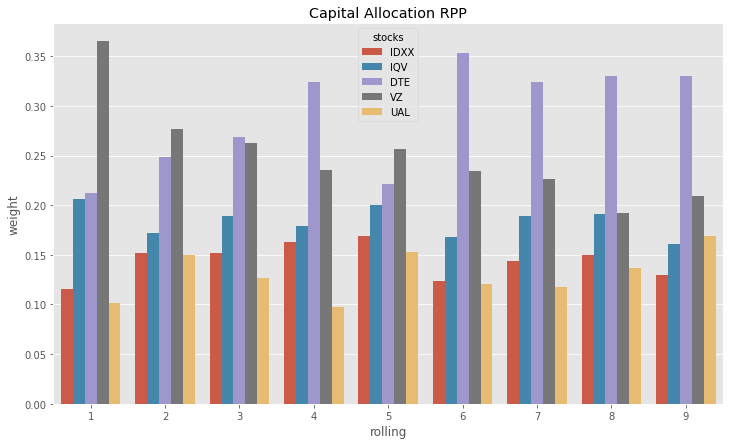

In [14]:
# plot to compare the allocations
plt.figure(figsize=(12, 7))
ax = sns.barplot(x = 'rolling', y = 'weight', hue='stocks', data= df)
ax.set_title("Capital Allocation RPP")

In [15]:
def calculate_HRP(c,sig):
    X = cp.Variable(5)
    objective = cp.Minimize(1/2 * cp.quad_form(X, sig) - c * cp.log(X))
    constraint = [X >= 0]
    prob = cp.Problem(objective, constraints = constraint)
    result = prob.solve()
    x = X.value
    w = x / (np.ones(5).T @ x)
    return w

In [16]:
weight_HRP = []

for i in range(len(t_return) - 1):
    sig = np.cov(t_return[i].T)
    sortIx = hrp_s12(sig, top_5, ifplot = False)
    weight_HRP.append(hrp_s3(sig, top_5, sortIx))

weights_reshaped = np.vstack(weight_HRP).flatten()

time_rep = np.repeat(time, len(top_5))
df = pd.DataFrame({'weight': weights_reshaped, 'rolling': time_rep, 'stocks': stocks_rep})

Text(0.5, 1.0, 'Capital Allocation HRP')

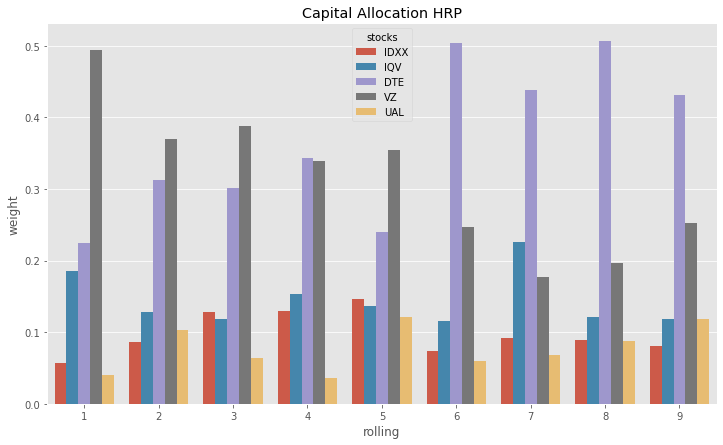

In [17]:
# plot to compare the allocations
plt.figure(figsize=(12, 7))
ax = sns.barplot(x = 'rolling', y = 'weight', hue='stocks', data= df)
ax.set_title("Capital Allocation HRP")

In [18]:
weight_GMVP = []
def GMVP(Sigma):
    ones = np.ones(Sigma.shape[0])
    Sigma_inv_1 = np.linalg.solve(Sigma, ones) # same as Sigma_inv @ ones
    w = Sigma_inv_1 / (np.sum(Sigma_inv_1))
    return w

for i in range(len(t_return) - 1):
    sig = np.cov(t_return[i].T)
    weight_GMVP.append(GMVP(sig))


Text(0.5, 1.0, 'Capital Allocation GMVP')

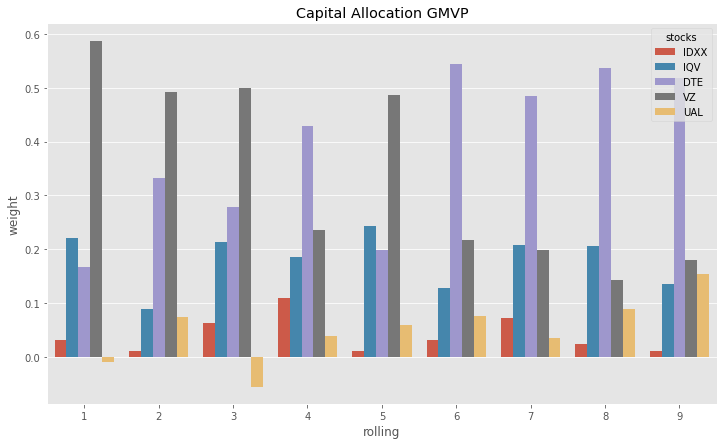

In [19]:
weights_reshaped = np.vstack(weight_GMVP).flatten()
stocks_rep = np.tile(top_5, len(time))

df = pd.DataFrame({'weight': weights_reshaped, 'rolling': time_rep, 'stocks': stocks_rep})
plt.figure(figsize=(12, 7))
ax = sns.barplot(x = 'rolling', y = 'weight', hue='stocks', data= df)
ax.set_title("Capital Allocation GMVP")

In [20]:
RPP_df = pd.DataFrame()
HRP_df = pd.DataFrame()
GMVP_df = pd.DataFrame()
for i in range(9):
    log_return_RPP = t_return[i + 1] @ weight_RPP[i]
    RPP_df = pd.concat([RPP_df, log_return_RPP], axis=0)
    
    log_return_HRP = t_return[i + 1] @ weight_HRP[i]
    HRP_df = pd.concat([HRP_df, log_return_HRP], axis=0)
    
    log_return_GMVP = t_return[i + 1] @ weight_GMVP[i]
    GMVP_df = pd.concat([GMVP_df, log_return_GMVP], axis=0)
    
merged_data_frame = pd.concat([RPP_df, HRP_df, GMVP_df], axis=1)
merged_data_frame.columns = ['RPP', 'HRP','GMVP']

In [21]:
merged_data_frame

,RPP,HRP,GMVP
2015-06-01,0.002506,-0.000031,-0.001782
2015-06-02,-0.007391,-0.006684,-0.005421
2015-06-03,-0.005573,-0.004974,-0.003833
2015-06-04,-0.009418,-0.010678,-0.011480
2015-06-05,-0.013367,-0.014919,-0.014666
...,...,...,...
2018-12-18,0.002853,0.000296,-0.000458
2018-12-19,-0.006384,-0.003606,-0.003252
2018-12-20,-0.009135,-0.006848,-0.007089
2018-12-21,-0.010985,-0.008904,-0.010649


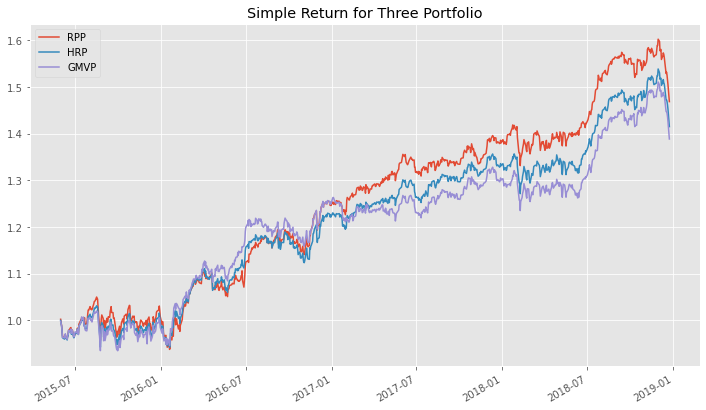

In [22]:
all_return = 1 + np.cumsum(np.exp(merged_data_frame)-1)

all_return.plot(title="Simple Return for Three Portfolio", figsize=(12, 7))
plt.show()

In [23]:
SH_weight_GMVP = []
SH_weight_RPP = []
SH_weight_HRP = []

rho = 0.3
for i in range(len(t_return) - 1):
    sig = np.cov(t_return[i].T)
    N = sig.shape[0]
    iden = np.eye(N)
    Tar = 1/N * np.sum(np.diag(sig)) * iden
    sig_SH = (1 - rho) * sig + rho * Tar
    SH_weight_GMVP.append(GMVP(sig_SH))
    
    sortIx_SH = hrp_s12(sig_SH, top_5, ifplot = False)
    SH_weight_HRP.append(hrp_s3(sig_SH, top_5, sortIx_SH))
    
    SH_weight_RPP.append(calculate_RPP(c,sig_SH))

In [24]:
SH_RPP_df = pd.DataFrame()
SH_HRP_df = pd.DataFrame()
SH_GMVP_df = pd.DataFrame()
for i in range(9):
    SH_log_return_RPP = t_return[i + 1] @ SH_weight_RPP[i]
    SH_RPP_df = pd.concat([SH_RPP_df, SH_log_return_RPP], axis=0)
    
    SH_log_return_HRP = t_return[i + 1] @ SH_weight_HRP[i]
    SH_HRP_df = pd.concat([SH_HRP_df, SH_log_return_HRP], axis=0)
    
    SH_log_return_GMVP = t_return[i + 1] @ SH_weight_GMVP[i]
    SH_GMVP_df = pd.concat([SH_GMVP_df, SH_log_return_GMVP], axis=0)
    

In [25]:
SH_merged_data_frame = pd.concat([SH_RPP_df, SH_HRP_df, SH_GMVP_df], axis=1)
SH_merged_data_frame.columns = ['SH_RPP', 'SH_HRP','SH_GMVP']

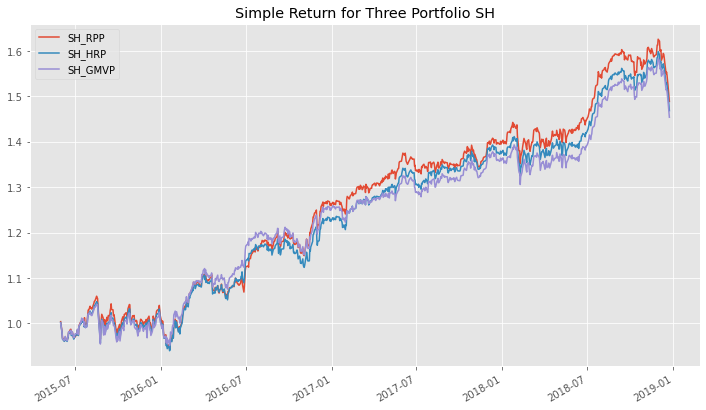

In [26]:
SH_all_return = 1 + np.cumsum(np.exp(SH_merged_data_frame)-1)

SH_all_return.plot(title="Simple Return for Three Portfolio SH", figsize=(12, 7))
plt.show()